In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
path = '/content/drive/MyDrive/Colab Notebooks/TFM_en_colab'
os.chdir(path)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
regressors = {
    'LR': LinearRegression(),
    'adaBoostRegressor': AdaBoostRegressor(random_state=256),
    'baggingRegressor': BaggingRegressor(random_state=256),
    'GBR': GradientBoostingRegressor(random_state=256),
    'DT': DecisionTreeRegressor(random_state=256)
}

params = {
    'LR':{
        'fit_intercept':[True, False]
    },
    'adaBoostRegressor':{
        'n_estimators':[2,4,8,16,32,64,128],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'loss':['linear','square']
    },
    'baggingRegressor':{
        'n_estimators':[2,4,8,16,32,64],
        'max_samples':[5,10,25,40],
        'max_features':[1,2,3]
    },
    'GBR':{
        'loss':['squared_error','absolute_error'],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'n_estimators':[2,4,8,16,32,64],
        'validation_fraction':[0.05, 0.1, 0.2], # subconjunto de validacion
        'n_iter_no_change':[2,3, 5, 10], # tras varias iteraciones loss function no mejora, fin del entrenamiento
        'tol':[1e-4, 1e-3, 1e-2, 1e-1], # una tolerancia al decrecimiento
    },
    'DT':{
        'criterion':['squared_error','absolute_error','poisson'],
        'max_depth':[None,1,2,3,4],
        'min_samples_split':[2,4,8,16,32],
        'min_samples_leaf': [1,2,3,5,10,20]
    }
}


In [4]:
scoring = {
    'r2': 'r2',
    'mape':'neg_mean_absolute_percentage_error',
    'mae': 'neg_mean_absolute_error',
    'medae':'neg_median_absolute_error',
    'rmsle': 'neg_root_mean_squared_log_error',
    'mpd':'neg_mean_poisson_deviance'
}


## Modelos Puerto de Newark:

### Datos Newark sin transformar

In [6]:
newark_data = pd.read_csv('../sources/newark_data.csv')


/home/gonzalopc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


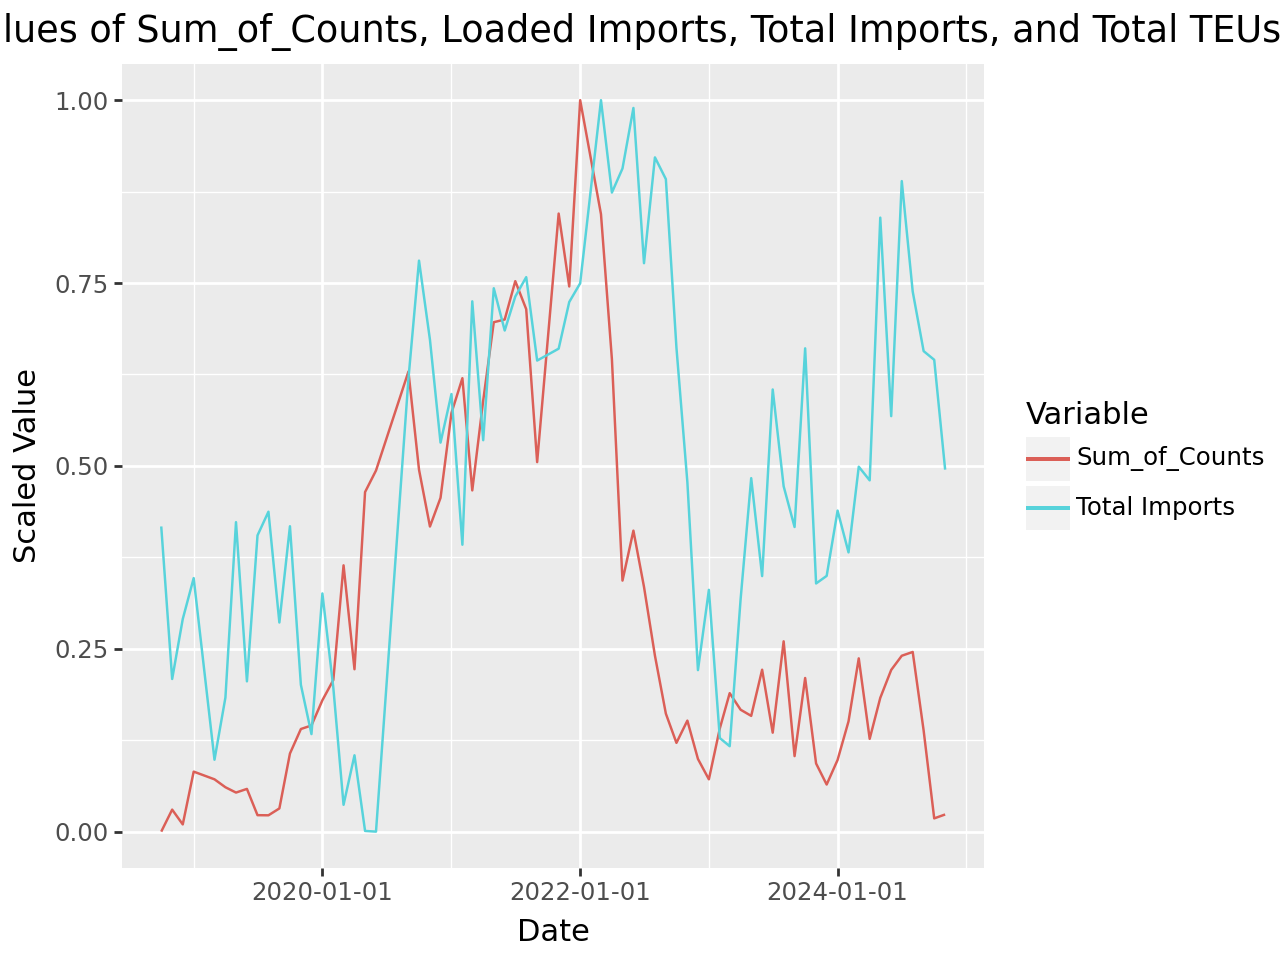

In [7]:
from plotnine import ggplot, aes, geom_line, labs
from sklearn.preprocessing import MinMaxScaler

# Select the columns to plot
columns_to_plot = ['Sum_of_Counts', 'Total Imports']

# Apply MinMaxScaler to the selected columns
scaler = MinMaxScaler()
newark_data_scaled = newark_data.copy()
newark_data_scaled[columns_to_plot] = scaler.fit_transform(newark_data[columns_to_plot])

# Melt the dataframe for plotting
newark_data_melted = newark_data_scaled.melt(id_vars=['Date'], value_vars=columns_to_plot, var_name='Variable', value_name='Value')

# Convert 'Date' to datetime
newark_data_melted['Date'] = pd.to_datetime(newark_data_melted['Date'])

# Plot using plotnine
plot = (ggplot(newark_data_melted, aes(x='Date', y='Value', color='Variable'))
    + geom_line()
    + labs(title='Scaled Values of Sum_of_Counts, Loaded Imports, Total Imports, and Total TEUs',
           x='Date', y='Scaled Value'))

plot

In [8]:
newark_data_input = newark_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Ratio_Cocaine']]
newark_data_input_corr = newark_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Ratio_Cocaine']]

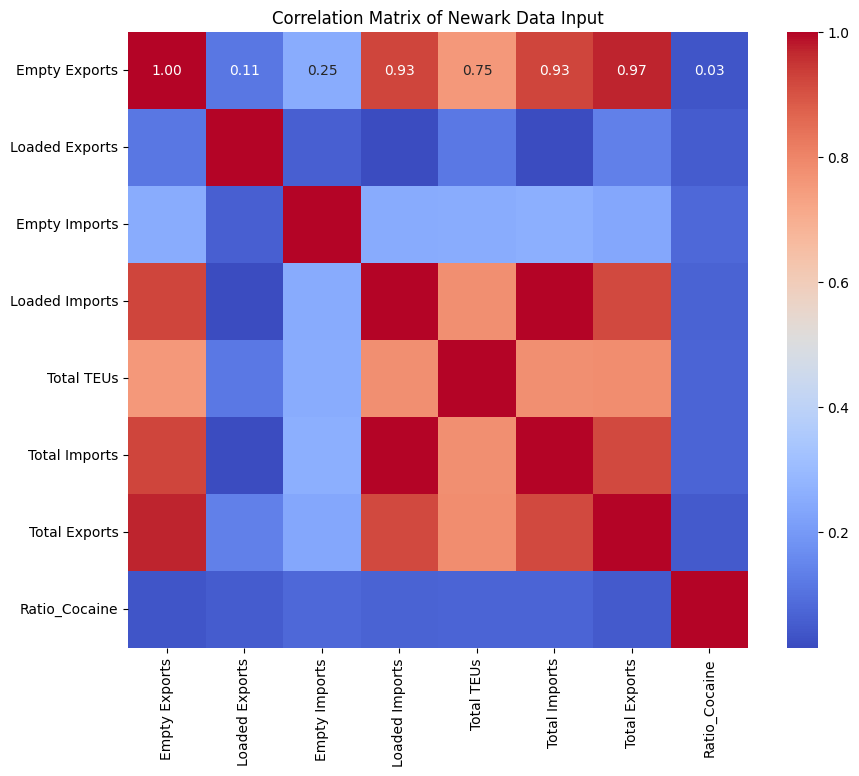

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = newark_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Newark Data Input')
plt.show()

In [ ]:

X = newark_data_input.drop('Ratio_Cocaine', axis=1)
y = newark_data_input['Ratio_Cocaine']

# Opcion A: Division como train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the training data
y_train_pred = rf_regressor.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training MSE: {train_mse}')
print(f'Training R2: {train_r2}')

# Predict on the test data
y_test_pred = rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')

In [ ]:
# Define the features and target variable
X_filtered = newark_data_input.drop(['Date', 'Ratio_Cocaine'], axis=1)
y_filtered = newark_data_input['Ratio_Cocaine']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestRegressor
rf_regressor_ts = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
for train_index, test_index in tscv.split(X_filtered):
    X_train_ts, X_test_ts = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
    y_train_ts, y_test_ts = y_filtered.iloc[train_index], y_filtered.iloc[test_index]

    # Fit the model
    rf_regressor_ts.fit(X_train_ts, y_train_ts)

    # Predict on the test data
    y_test_pred_ts = rf_regressor_ts.predict(X_test_ts)

    # Evaluate the model
    test_mse_ts = mean_squared_error(y_test_ts, y_test_pred_ts)
    test_r2_ts = r2_score(y_test_ts, y_test_pred_ts)

    print(f'Test MSE: {test_mse_ts}')
    print(f'Test R2: {test_r2_ts}')

### Datos Newark Transformados

In [ ]:
# newark_data = pd.read_csv('../sources/newark_data_treated.csv')
newark_data = pd.read_csv('newark_data_treated.csv')

In [ ]:
newark_data_input = newark_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]
newark_data_input_corr = newark_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]

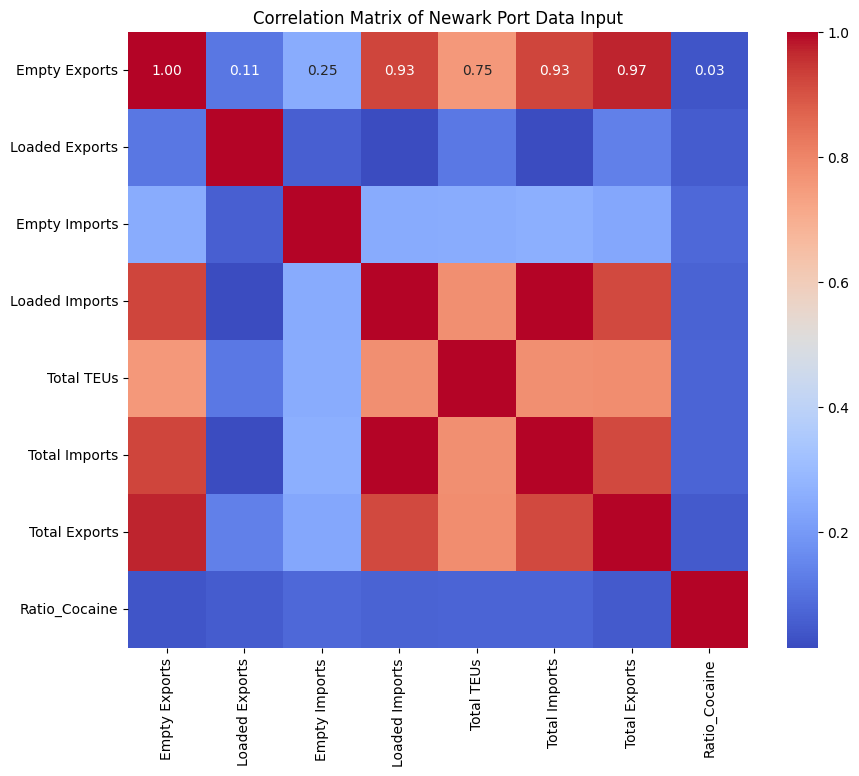

In [12]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = newark_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Newark Port Data Input')
plt.show()

In [ ]:
# Use last year for test
# Convert 'Date' to datetime
newark_data_input['Date'] = pd.to_datetime(newark_data_input['Date'])

# Split the data
train_data = newark_data_input[newark_data_input['Date'] < '2024-01-01']
test_data = newark_data_input[newark_data_input['Date'] >= '2024-01-01']

In [ ]:
# Define the features and target variable for train_data
X_train = train_data.drop(['Sum_of_Counts','Date'], axis=1)
y_train = train_data['Sum_of_Counts']

# Define the features and target variable for test_data
X_test = test_data.drop(['Sum_of_Counts','Date'], axis=1)
y_test = test_data['Sum_of_Counts']

In [ ]:
regressorsCV = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring= 'neg_mean_absolute_percentage_error', #scoring,
        refit='mape',
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV[name].fit(X_train, y_train)

In [ ]:
test_scores = []

for name in list(params.keys()):
    print(name)
    print("Numero de configuraciones: ", pd.DataFrame.from_dict(regressorsCV[name].cv_results_).shape[0])

    # Get sorted results, ensuring lower MAPE is better
    aux = pd.DataFrame.from_dict(regressorsCV[name].cv_results_).sort_values(by="mean_test_score", ascending=True).iloc[0]

    # Ensure MAPE is positive
    mape_cv_test = abs(aux['mean_test_score'])
    mape_cv_train = abs(aux['mean_train_score'])

    # Get best model and compute MAPE
    best_model = regressorsCV[name].best_estimator_
    mape_train = mean_absolute_percentage_error(y_train, best_model.predict(X_train))
    mape_test = mean_absolute_percentage_error(y_test, best_model.predict(X_test))

    test_scores.append((name, mape_train, mape_cv_train, mape_cv_test, mape_test))


In [ ]:
resultado = pd.DataFrame(test_scores,columns=['Regressor','mape_train','mape_cv_train','mape_validation','mape_test'])
resultado

Versión alternativa tras eliminar columnas redundantes:

In [ ]:
newark_data_input_2 = newark_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs','Sum_of_Counts']]

In [ ]:
# Use last year for test
# Convert 'Date' to datetime
newark_data_input_2['Date'] = pd.to_datetime(newark_data_input_2['Date'])

# Split the data
train_data_2 = newark_data_input_2[newark_data_input_2['Date'] < '2024-01-01']
test_data_2 = newark_data_input_2[newark_data_input_2['Date'] >= '2024-01-01']

In [ ]:
# Define the features and target variable for train_data
X_train_2 = train_data_2.drop(['Sum_of_Counts','Date'], axis=1)
y_train_2 = train_data_2['Sum_of_Counts']

# Define the features and target variable for test_data
X_test_2 = test_data_2.drop(['Sum_of_Counts','Date'], axis=1)
y_test_2 = test_data_2['Sum_of_Counts']

In [ ]:
regressorsCV_2 = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV_2[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring= 'r2', #scoring,
        refit='r2',
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV_2[name].fit(X_train_2, y_train_2)

In [ ]:
test_scores_2b = []

for name in list(params.keys()):
    print(name)
    print("Numero de configuraciones: ", pd.DataFrame.from_dict(regressorsCV_2[name].cv_results_).shape[0])

    # Get sorted results, ensuring lower MAPE is better
    aux = pd.DataFrame.from_dict(regressorsCV_2[name].cv_results_).sort_values(by="mean_test_score", ascending=True).iloc[0]

    # Ensure MAPE is positive
    r2_cv_test = aux['mean_test_score']
    r2_cv_train = aux['mean_train_score']

    # Get best model and compute MAPE
    best_model = regressorsCV_2[name].best_estimator_
    r2_train = r2_score(y_train_2, best_model.predict(X_train_2))
    r2_test = r2_score(y_test_2, best_model.predict(X_test_2))

    test_scores_2b.append((name, r2_train, r2_cv_train, r2_cv_test, r2_test))


In [ ]:
resultado_2 = pd.DataFrame(test_scores_2,columns=['Regressor','mape_train','mape_cv_train','mape_validation','mape_test'])
resultado_2

In [ ]:
resultado_b = pd.DataFrame(test_scores_2b,columns=['Regressor','r2_train','r2_cv_train','r2_validation','r2_test'])
resultado_b

Eliminando más columnas redundantes

In [ ]:
newark_data_input_3 = newark_data.loc[:,['Date','Empty Exports','Total Imports','Sum_of_Counts']]

newark_data_input_3['Date'] = pd.to_datetime(newark_data_input_3['Date'])

# Split the data
train_data_3 = newark_data_input_3[newark_data_input_3['Date'] < '2024-01-01']
test_data_3 = newark_data_input_3[newark_data_input_3['Date'] >= '2024-01-01']

# Define the features and target variable for train_data
X_train_3 = train_data_3.drop(['Sum_of_Counts','Date'], axis=1)
y_train_3 = train_data_3['Sum_of_Counts']

# Define the features and target variable for test_data
X_test_3 = test_data_3.drop(['Sum_of_Counts','Date'], axis=1)
y_test_3 = test_data_3['Sum_of_Counts']

In [ ]:
regressorsCV_3 = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV_3[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring= 'neg_mean_absolute_percentage_error', #scoring,
        refit='mape',
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV_3[name].fit(X_train_3, y_train_3)

In [ ]:
test_scores_3 = []

for name in list(params.keys()):
    print(name)
    print("Numero de configuraciones: ", pd.DataFrame.from_dict(regressorsCV_3[name].cv_results_).shape[0])

    # Get sorted results, ensuring lower MAPE is better
    aux = pd.DataFrame.from_dict(regressorsCV_3[name].cv_results_).sort_values(by="mean_test_score", ascending=True).iloc[0]

    # Ensure MAPE is positive
    mape_cv_test = aux['mean_test_score']
    mape_cv_train = aux['mean_train_score']

    # Get best model and compute MAPE
    best_model = regressorsCV_3[name].best_estimator_
    mape_train = mean_absolute_percentage_error(y_train_3, best_model.predict(X_train_3))
    mape_test = mean_absolute_percentage_error(y_test_3, best_model.predict(X_test_3))

    test_scores_3.append((name, mape_train, mape_cv_train, mape_cv_test, mape_test))


In [ ]:
resultado_3b = pd.DataFrame(test_scores_3b,columns=['Regressor','r2_train','r2_cv_train','r2_validation','r2_test'])
resultado_3b

In [ ]:
resultado_3 = pd.DataFrame(test_scores_3,columns=['Regressor','mape_train','mape_cv_train','mape_validation','mape_test'])
resultado_3

## Modelos Puerto de Everglades:

In [13]:
everglades_data = pd.read_csv('../sources/everglades_data.csv')

In [14]:
everglades_data_input = everglades_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]
everglades_data_input_corr = everglades_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]

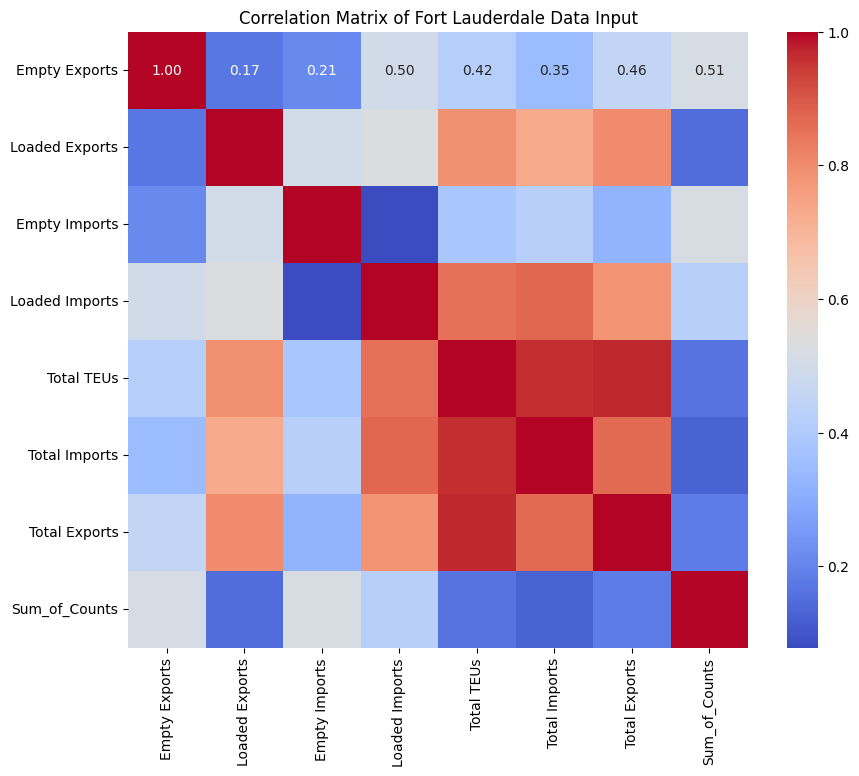

In [15]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = everglades_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fort Lauderdale Data Input')
plt.show()

In [ ]:
# Use last year for test
# Convert 'Date' to datetime
everglades_data_input['Date'] = pd.to_datetime(everglades_data_input['Date'])

# Split the data
train_data = everglades_data_input[everglades_data_input['Date'] < '2024-01-01']
test_data = everglades_data_input[everglades_data_input['Date'] >= '2024-01-01']

In [ ]:
# Define the features and target variable for train_data
X_train = train_data.drop('Sum_of_Counts', axis=1)
y_train = train_data['Sum_of_Counts']

# Define the features and target variable for test_data
X_test = test_data.drop('Sum_of_Counts', axis=1)
y_test = test_data['Sum_of_Counts']

In [ ]:
regressors = {
    'LR', LinearRegression(),
    'adaBoostRegressor', AdaBoostRegressor(random_state=256),
    'baggingRegressor', BaggingRegressor(random_state=256),
    'GBR', GradientBoostingRegressor(random_state=256)
}

params = {
    'LR':{
        'fit_intercept':[True, False]
    },
    'adaBoostRegressor':{
        'n_estimators':[2,4,8,16,32,64],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'loss':['linear','square']
    },
    'baggingRegressor':{
        'n_estimators':[2,4,8,16,32,64],
        'max_samples':[5,10,25,40],
        'max_features':[1,2,3]
    },
    'GBR':{
        'loss':['linear','square'],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 1e2],
        'n_estimators':[2,4,8,16,32,64],
        'validation_fraction':[0.05, 0.1, 0.2], # subconjunto de validacion
        'n_iter_no_change':[2,3, 5, 10], # tras varias iteraciones loss function no mejora, fin del entrenamiento
        'tol':[1e-4, 1e-3, 1e-2, 1e-1], # una tolerancia al decrecimiento
    }
}


In [ ]:
regressorsCV = {}

for name in list(params.keys()):
    print("*************")
    print(name)
    print("*************")
    regressorsCV[name] = GridSearchCV(
        estimator=regressors[name],
        param_grid=params[name],
        scoring=['mean_squared_error','r2_score'],
        return_train_score=True,
        n_jobs=-1,
        cv=5, verbose = 2
    )

    regressorsCV[name].fit(X_train, y_train)

In [ ]:
# compute results
test_scores = []


for name in list(params.keys()):
    print(name)
    print("Número de configuraciones: ", pd.DataFrame.from_dict(regressorsCV[name].cv_results_).shape[0])
    aux = pd.DataFrame.from_dict(regressorsCV[name].cv_results_).sort_values(by="mean_test_score",ascending=False).iloc[0]

    # Accuracy
    mse_cv_test = aux['mean_test_score']
    mse_cv_train = aux['mean_train_score']

    mse_train = mean_squared_error(y_train, regressorsCV[name].predict(X_train))
    mse_test = mean_squared_error(y_test, regressorsCV[name].predict(X_test))

    # R2:
    r2_train = r2_score(y_train, regressorsCV[name].predict(X_train))
    r2_test = r2_score(y_test, regressorsCV[name].predict(X_test))

    test_scores.append((name,mse_train,mse_cv_train,mse_cv_test,mse_test,r2_train,r2_test))

# mirar el rendimiento en validacion para obtener el mejor modelo
resultado = pd.DataFrame(test_scores,columns=['Regressor','mse_train','mse_CV_train','mse_validation','mse_test','r2_train','r2_test'])
sorted_resultado = resultado.sort_values(by="mse_validation",ascending=False)

In [ ]:
sorted_resultado

## Modelo de series temporales

In [ ]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [ ]:
everglades_data = pd.read_csv('everglades_data.csv')

Serie temporal para Loaded Imports en Miami/Fort Lauderdale:

In [ ]:
# Añadir 'Loaded Imports' como variable exógena para predecir "Count of Event_Other Drugs**"
df_imports = everglades_data[['Date', 'Count of Event_Other Drugs**','Loaded Imports']]

In [ ]:
df_imports['Date'] = pd.to_datetime(df_imports['Date'])
df_imports_train = df_imports[df_imports['Date'] < '2024-01-01']
df_imports_test = df_imports[df_imports['Date'] >= '2024-01-01']


In [ ]:
df_imports_train = df_imports_train.rename(columns={
    'Date': 'ds', 
    'Count of Event_Other Drugs**': 'y'  # This should be your target variable
})

df_imports_test = df_imports_test.rename(columns={
    'Date': 'ds', 
    'Count of Event_Other Drugs**': 'y'  # This should be your target variable
})

In [ ]:
# Ensure column names are correctly formatted
df_imports_train.columns = df_imports_train.columns.str.strip()
df_imports_test.columns = df_imports_test.columns.str.strip()

In [ ]:
# df_imports_train['cap'] = 0.5
m = Prophet()
m.add_regressor('Loaded Imports')
m.fit(df_imports_train)

In [ ]:
prediction = m.predict(df_imports_test)
print(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

In [ ]:
# Make future dataframe for prediction
future = m.make_future_dataframe(periods=len(df_imports_test))
# Add the regressor values for both training and prediction periods
future['Loaded Imports'] = pd.concat([df_imports_train['Loaded Imports'], df_imports_test['Loaded Imports']])

# Make predictions
forecast = m.predict(future)

In [ ]:
# Get in-sample predictions (trend component)
train_forecast = m.predict(df_imports_train)
df_imports_train['trend'] = train_forecast['trend']


In [ ]:
plt.figure(figsize=(12,6))

# Plot training data
plt.scatter(df_imports_train['ds'], df_imports_train['y'], color='green', label="Training Data", alpha=0.6)

# Plot trendline for training data
plt.plot(df_imports_train['ds'], df_imports_train['trend'], color='blue', linewidth=2, linestyle='dashed', label="Training Trend")

# Other plot elements (forecast, test data, regressor)
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3, color='blue', label="95% Confidence")
plt.scatter(df_imports_test['ds'], df_imports_test['y'], color='orange', label="Test Data (Actual)", alpha=0.7)
plt.plot(df_imports['Date'], df_imports['Loaded Imports'], color='purple', linestyle='dashed', label="Loaded Imports")

plt.xlabel("Date")
plt.ylabel("Count of Drug Events")
plt.title("Prophet Forecast with Training Trendline")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
df_imports_st = df_imports.copy()
df_imports_st.rename({'Date':'ds'}, inplace=True, axis=1)

In [ ]:
# Crear el dataframe futuro con la misma frecuencia de los datos originales
future = m.make_future_dataframe(periods=len(df_imports_test), freq='M')

# Unir los valores reales de 'Loaded Imports' de train y test
future = future.merge(df_imports_st[['ds', 'Loaded Imports']], on='ds', how='left')

# Rellenar valores faltantes de la regresora
future['Loaded Imports'].fillna(method='ffill', inplace=True)

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Create the forecast plot with both predicted and actual values
def plot_prophet_forecast(model, forecast, df_train, df_test, target_col='y', regressor_col='Loaded Imports'):
    """
    Create a comprehensive visualization of Prophet forecast results
    
    Parameters:
    -----------
    model : Prophet model
        The fitted Prophet model
    forecast : DataFrame
        The forecast DataFrame from model.predict()
    df_train : DataFrame
        Training data with 'ds' and target column
    df_test : DataFrame
        Test data with 'ds' and target column
    target_col : str
        Name of the target column (default: 'y')
    regressor_col : str
        Name of the regressor column (default: 'Loaded Imports')
    """
    # Create figure and primary axis for the forecast
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Set a professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Plot the forecast line with uncertainty intervals
    ax1.plot(forecast['ds'], forecast['yhat'], color='#0072B2', linewidth=2, label='Forecast')
    ax1.fill_between(forecast['ds'], 
                     forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='#0072B2', alpha=0.2, label='95% Confidence Interval')
    
    # Plot the actual training data points
    ax1.plot(df_train['ds'], df_train[target_col], 'o', color='#009E73', 
             markersize=4, alpha=0.7, label='Training Data')
    
    # Plot the actual test data points to compare with forecast
    ax1.plot(df_test['ds'], df_test[target_col], 'o', color='#D55E00', 
             markersize=6, label='Test Data (Actual)')
    
    # Enhance the x-axis with better date formatting
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    
    # Create a secondary y-axis for the regressor
    ax2 = ax1.twinx()
    
    # Plot the regressor values (Loaded Imports)
    combined_df = pd.concat([df_train, df_test])
    ax2.plot(combined_df['ds'], combined_df[regressor_col], '--', color='#CC79A7', 
             linewidth=1.5, label=regressor_col)
    
    # Calculate correlation to add to the plot
    correlation = combined_df[[target_col, regressor_col]].corr().iloc[0, 1]
    
    # Determine cross-validation metrics if possible
    cv_metrics = None
    try:
        from prophet.diagnostics import cross_validation, performance_metrics
        cv_results = cross_validation(model, initial='180 days', period='30 days', horizon='90 days')
        cv_metrics = performance_metrics(cv_results)
        mape = cv_metrics['mape'].mean()
        rmse = cv_metrics['rmse'].mean()
        metrics_text = f'MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}'
    except:
        metrics_text = ''
    
    # Add correlation and metrics information
    plt.figtext(0.15, 0.02, 
                f'Correlation between target and regressor: {correlation:.2f}\n{metrics_text}',
                fontsize=10, ha='left')
    
    # Set titles and labels with clear descriptions
    ax1.set_title('Prophet Forecast of Drug Events with Loaded Imports as Regressor', 
                  fontsize=16, pad=20)
    ax1.set_xlabel('Date', fontsize=12, labelpad=10)
    ax1.set_ylabel('Count of Drug Events', fontsize=12, labelpad=10, color='#0072B2')
    ax2.set_ylabel(regressor_col, fontsize=12, labelpad=10, color='#CC79A7')
    
    # Create a combined legend for both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Improve the layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    # Add performance indicators - trend component, seasonality, etc.
    if len(model.seasonalities) > 0:
        ax3 = plt.axes([0.15, 0.85, 0.25, 0.1], facecolor='whitesmoke')
        components = ['trend']
        components.extend(list(model.seasonalities.keys()))
        for comp in components[:3]:  # Limit to first 3 components
            if comp in forecast:
                ax3.plot(forecast['ds'], forecast[comp], label=comp)
        ax3.legend(loc='center left', fontsize=8)
        ax3.set_title('Key Components', fontsize=8)
        ax3.xaxis.set_visible(False)
    
    return fig

# Use the function to create your plot
fig = plot_prophet_forecast(
    model=m,
    forecast=forecast,
    df_train=df_imports_train,
    df_test=df_imports_test,
    target_col='y',  # This is 'Count of Event_Other Drugs**' renamed
    regressor_col='Loaded Imports'
)

# Show the plot
plt.show()

# If you want to save the plot to a file
# fig.savefig('drug_events_forecast.png', dpi=300, bbox_inches='tight')

In [ ]:
# Plot the forecast
fig = m.plot(prediction)
ax = fig.gca()

# Plot the actual values
ax.plot(df_imports_test['ds'], df_imports_test['y'], 'r.', label='Actual')

# Customize the plot
plt.legend()
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Loaded Imports')
plt.show()

In [ ]:

# Plot the forecast
fig = m.plot(prediction)
ax = fig.gca()

# Plot the actual values
ax.plot(df_imports_test['ds'], df_imports_test['y'], 'r.', label='Actual')
a = add_changepoints_to_plot(fig.gca(), m, prediction)

# Customize the plot
plt.legend()
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Loaded Imports')
plt.show()

Opcion 2:

In [ ]:
df_imports_train

In [ ]:
# Specify the dates where you want changepoints to occur
changepoints = pd.to_datetime(['2020-05-01', '2022-04-01', '2023-06-01']).to_list()
m = Prophet(changepoints=changepoints)

# Add your regressor
m.add_regressor('Loaded Imports')

# Fit the model
m.fit(df_imports_train)

In [ ]:
# Generate the forecast
future = m.make_future_dataframe(periods=len(df_imports_test))
future['Loaded Imports'] = pd.concat([df_imports_train['Loaded Imports'], df_imports_test['Loaded Imports']])
forecast = m.predict(future)

# Plot the forecast with changepoints
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('Forecast with Changepoints')
plt.xlabel('Date')
plt.ylabel('Count of Drug Events')
plt.show()

In [ ]:
# Import cross-validation tools
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import itertools

# Define parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'changepoint_range': [0.8, 0.9, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSE for each parameter combination

# Cross-validation for each parameter combination
for params in all_params:
    # Create and fit model with current parameters
    m = Prophet(**params)
    m.add_regressor('Loaded Imports')
    m.fit(df_imports_train)
    
    # Cross-validate
    df_cv = cross_validation(m, initial='180 days', period='30 days', horizon='90 days', parallel="processes")
    
    # Calculate metrics
    df_metrics = performance_metrics(df_cv)
    rmses.append(df_metrics['rmse'].mean())
    
    # Print current parameters and RMSE
    print(f"Parameters: {params}, RMSE: {rmses[-1]:.2f}")

# Find the best parameters
best_params = all_params[np.argmin(rmses)]
print(f"\nBest parameters: {best_params}, RMSE: {min(rmses):.2f}")

In [ ]:
# Create a Prophet model with adjusted changepoint settings
m = Prophet(
    changepoint_prior_scale=0.01,  # Controls flexibility (default is 0.05)
    changepoint_range=0.8,        # Where changepoints can occur (default is 0.8)
    n_changepoints=30             # Number of potential changepoints (default is 25)
)

# Add your regressor
m.add_regressor('Loaded Imports')

# Fit the model
m.fit(df_imports_train)

# Make future dataframe for prediction
future = m.make_future_dataframe(periods=len(df_imports_test))
# Add the regressor values for both training and prediction periods
future['Loaded Imports'] = pd.concat([df_imports_train['Loaded Imports'], df_imports_test['Loaded Imports']])

# Make predictions
forecast = m.predict(df_imports_test)



In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import r2_score

# Get the actual values from the test dataset
y_true = df_imports_test['y'].values  # Assuming 'y' is your target variable

# Get the predicted values
# Note: We need to match the predictions with the test period
# The forecast DataFrame from Prophet contains multiple columns including 'yhat' (predictions)
y_pred = forecast['yhat'].values

# Calculate R² (R-squared)
r2 = r2_score(y_true, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
# We need to handle division by zero, so we'll add a small epsilon to avoid it
epsilon = 1e-10
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Print the results
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


In [ ]:

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_imports_test.ds, y_true, 'b-', label='Actual Test')

# Plot predicted values
plt.plot(df_imports_test.ds, y_pred, 'r--', label='Predicted Test')

plt.title('Actual vs Predicted Values (For 2024, Test)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a scatter plot of actual vs predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Scatter Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plot the forecast with changepoints
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)

# Add points for df_imports_test
plt.plot(df_imports_test['ds'], df_imports_test['y'], 'ro', label='Test Data')

plt.title('Forecast with Changepoints')
plt.xlabel('Date')
plt.ylabel('Count of Drug Events')
plt.legend()
plt.show()

In [ ]:
# Make predictions
forecast = m.predict(future)

fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)
plt.plot(df_imports_test['ds'], df_imports_test['y'], 'ro', label='Test Data')
plt.title('Forecast with Changepoints')
plt.xlabel('Date')
plt.ylabel('Count of Drug Events')
plt.show()

Prueba sin contenedores:

In [ ]:
df_imports = everglades_data[['Date', 'Count of Event_Other Drugs**']]

df_imports['Date'] = pd.to_datetime(df_imports['Date'])
df_imports_train = df_imports[df_imports['Date'] < '2024-01-01']
df_imports_test = df_imports[df_imports['Date'] >= '2024-01-01']

df_imports_train = df_imports_train.rename(columns={
    'Date': 'ds', 
    'Count of Event_Other Drugs**': 'y'  # This should be your target variable
})

df_imports_test = df_imports_test.rename(columns={
    'Date': 'ds', 
    'Count of Event_Other Drugs**': 'y'  # This should be your target variable
})

# Ensure column names are correctly formatted
df_imports_train.columns = df_imports_train.columns.str.strip()
df_imports_test.columns = df_imports_test.columns.str.strip()

m = Prophet()
m.fit(df_imports_train)

In [ ]:
prediction = m.predict(df_imports_test)
print(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

In [ ]:
# Make future dataframe for prediction
future = m.make_future_dataframe(periods=len(df_imports_test))

# Make predictions
forecast = m.predict(future, )

In [ ]:
# Make predictions
fig = m.plot(forecast)
# add_changepoints_to_plot(fig.gca(), m, forecast)
plt.plot(df_imports_test['ds'], df_imports_test['y'], 'ro', label='Test Data')
plt.title('Forecast with Changepoints')
plt.xlabel('Date')
plt.ylabel('Count of Drug Events')
plt.show()

Probar con scikit-learn

Probar con sarimax de statmodels

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Cargar los datos
file_path = "../sources/everglades_data.csv"
df = pd.read_csv(file_path)

# Seleccionar y renombrar las columnas necesarias
df_model = df[['Date', 'Ratio_Other Drugs**', 'Loaded Imports']].copy()
df_model.rename(columns={'Date': 'ds', 'Ratio_Other Drugs**': 'y', 'Loaded Imports': 'loaded_imports'}, inplace=True)

# Convertir la columna de fecha a datetime
df_model['ds'] = pd.to_datetime(df_model['ds'])

# Preparar los datos para SARIMAX
df_sarimax = df_model.set_index('ds')

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df_sarimax) * 0.8)
train, test = df_sarimax.iloc[:train_size], df_sarimax.iloc[train_size:]

# Ajustar el modelo SARIMAX
sarimax_model = SARIMAX(train['y'], exog=train[['loaded_imports']], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = sarimax_model.fit()

# Realizar predicciones
forecast_sarimax = sarimax_result.get_forecast(steps=len(test), exog=test[['loaded_imports']])
predicted_mean = forecast_sarimax.predicted_mean

# Combinar los resultados con los valores reales
results_sarimax = test.copy()
results_sarimax['Predicted_y'] = predicted_mean

# Mostrar los resultados
print(results_sarimax.head())


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Calculate R² and MAPE for train
r2_train_sarimax = r2_score(train['y'], sarimax_result.fittedvalues)
mape_train_sarimax = mean_absolute_percentage_error(train['y'], sarimax_result.fittedvalues)

# Calculate R² and MAPE for test
r2_test_sarimax = r2_score(results_sarimax['y'], results_sarimax['Predicted_y'])
mape_test_sarimax = mean_absolute_percentage_error(results_sarimax['y'], results_sarimax['Predicted_y'])

print(f"Train R²: {r2_train_sarimax}")
print(f"Train MAPE: {mape_train_sarimax}")
print(f"Test R²: {r2_test_sarimax}")
print(f"Test MAPE: {mape_test_sarimax}")

In [ ]:
results_sarimax.head()

In [ ]:
import matplotlib.pyplot as plt

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df_sarimax.index, df_sarimax['y'], label="Datos Originales", color='black', linestyle='dashed', alpha=0.7)
plt.plot(train.index, train['y'], label="Entrenamiento", color='blue', alpha=0.6)
plt.plot(test.index, test['y'], label="Test", color='green', alpha=0.6)
plt.plot(results_sarimax.index, results_sarimax['Predicted_y'], label="Predicción SARIMAX", color='red', linestyle='dashed')

plt.xlabel("Fecha")
plt.ylabel("Ratio_Other Drugs** (Escalado)")
plt.title("Predicción de SARIMAX con Loaded Imports como Regresor")
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


XGBoost, Random Forest

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Cargar los datos
file_path = "../sources/everglades_data.csv"
df = pd.read_csv(file_path)

# Seleccionar y renombrar las columnas necesarias
df_xgb = df[['Date', 'Ratio_Other Drugs**', 'Loaded Imports']].copy()
df_xgb.rename(columns={'Date': 'ds', 'Ratio_Other Drugs**': 'y', 'Loaded Imports': 'loaded_imports'}, inplace=True)

# Convertir la columna de fecha a datetime
df_xgb['ds'] = pd.to_datetime(df_xgb['ds'])

# Dividir en conjunto de entrenamiento y prueba según la regla dada
df_train = df_xgb[df_xgb['ds'] < '2024-01-01']
df_test = df_xgb[df_xgb['ds'] >= '2024-01-01']

# Definir características (X) y variable objetivo (y)
X_train, y_train = df_train[['loaded_imports']], df_train['y']
X_test, y_test = df_test[['loaded_imports']], df_test['y']

# Crear y entrenar el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

# Evaluar en train:
y_pred_xgb_train = xgb_model.predict(X_train)

# Evaluar el modelo en train
mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
mse_xgb_train = mean_squared_error(y_train, y_pred_xgb_train)
mape_xgb_train = mean_absolute_percentage_error(y_train, y_pred_xgb_train)
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)

# Imprimir métricas de error en train
print(f"MAE Train: {mae_xgb_train}")
print(f"MSE Train: {mse_xgb_train}")
print(f"MAPE Train: {mape_xgb_train}")
print(f"R2 Train: {r2_xgb_train}")

####################################
# Realizar predicciones en test
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Combinar los resultados con los valores reales
results_xgb = df_test.copy()
results_xgb['Predicted_y'] = y_pred_xgb

results_xgb_train = df_train.copy()
results_xgb_train['Predicted_y_train'] = y_pred_xgb_train

# Imprimir métricas de error en test
print(f"MAE Test: {mae_xgb}")
print(f"MSE Test: {mse_xgb}")
print(f"MAPE Test: {mape_xgb}")
print(f"R2 Test: {r2_xgb}")


In [ ]:
results_xgb.head()

In [ ]:
results_xgb_total = pd.concat([results_xgb, results_xgb_train]).sort_values(by="ds")

In [ ]:
results_xgb_total

In [ ]:
from plotnine import ggplot, aes, geom_point, labs, scale_color_manual, theme, element_blank

# Create the plot
plot = (ggplot(results_xgb_total, aes(x='ds'))
    + geom_point(aes(y='y', color='"Actual"'), size=2, alpha=0.6)
    + geom_point(aes(y='Predicted_y', color='"Predicted"'), size=2, alpha=0.6)
    + geom_point(aes(y='Predicted_y_train', color='"Predicted Train"'), size=2, alpha=0.6)
    + labs(title='Modelo con XGBoost',
           x='Date',
           y='Values')
    + scale_color_manual(values={"Actual": "blue", "Predicted": "red", "Predicted Train": "green"})
    + theme(legend_title=element_blank())
)


In [ ]:
# Display the plot
plot